# CNNs in Keras

Let’s build a simple CNN for image classification. In this example, we’ll use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset—a common benchmark dataset for image classification.

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Data Loading

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize image pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [4]:
(x_train.shape, y_train.shape)

((50000, 32, 32, 3), (50000, 10))

Visualize some of the CIFAR-10 images along with their class labels.

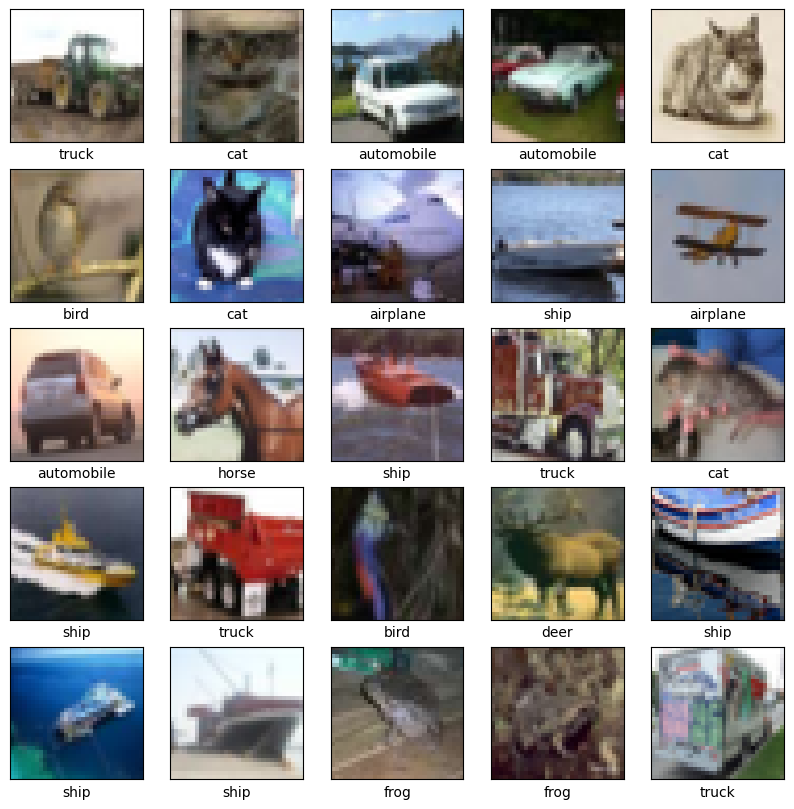

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

num_images = 25

# Randomly select indices from the training set
random_indices = np.random.choice(x_train.shape[0], num_images, replace=False)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[idx])
    plt.xlabel(class_names[np.argmax(y_train[idx])])
plt.show()

## Check on Class Balance

It is important to understand the distribution of labels in our data to observe whether we have class imbalance issues. In the following cell we check the class balance for both the training and testing sets. This example first converts one-hot encoded labels back to class indices (since we had converted the labels to one hot encoded vectors above), then calculates the number of samples per class using NumPy's bincount. Additionally, it provides a bar chart visualization of the class distribution.

Training set class distribution:
Class 0: 5000 samples
Class 1: 5000 samples
Class 2: 5000 samples
Class 3: 5000 samples
Class 4: 5000 samples
Class 5: 5000 samples
Class 6: 5000 samples
Class 7: 5000 samples
Class 8: 5000 samples
Class 9: 5000 samples

Testing set class distribution:
Class 0: 1000 samples
Class 1: 1000 samples
Class 2: 1000 samples
Class 3: 1000 samples
Class 4: 1000 samples
Class 5: 1000 samples
Class 6: 1000 samples
Class 7: 1000 samples
Class 8: 1000 samples
Class 9: 1000 samples


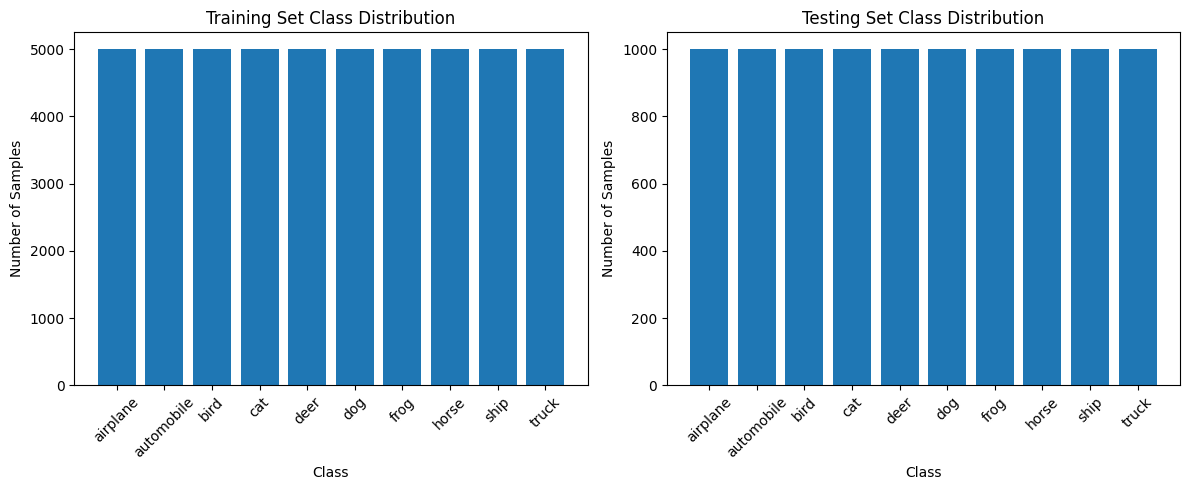

In [6]:
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_train_labels = y_train.flatten()
    y_test_labels = y_test.flatten()

# Calculate class counts using np.bincount
train_class_counts = np.bincount(y_train_labels)
test_class_counts = np.bincount(y_test_labels)

# Print out class distribution for training and testing sets
print("Training set class distribution:")
for i, count in enumerate(train_class_counts):
    print(f"Class {i}: {count} samples")

print("\nTesting set class distribution:")
for i, count in enumerate(test_class_counts):
    print(f"Class {i}: {count} samples")

# Visualize the class distribution using bar charts
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(np.arange(len(train_class_counts)), train_class_counts, tick_label=class_names)
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(np.arange(len(test_class_counts)), test_class_counts, tick_label=class_names)
plt.title('Testing Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Defining the Model Architecture

Here, we construct a sequential model with multiple convolutional and pooling layers. Later, we flatten the output and pass it to dense layers for classification.

In [7]:
model = Sequential()

# First convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the output and add fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

c:\Users\bigma\.virtualenvs\Pneumonia-Detection-1PsfeFAi\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,168,362 (8.27 MB)

 Trainable params: 2,168,362 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling and Training the Model

We compile the model with an appropriate optimizer, loss function, and evaluation metrics.

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

We train the model using the `.fit()` method, specifying the number of epochs and batch size.

In [10]:
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=30,
                    validation_split=0.2,
                    shuffle=True)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.3065 - loss: 1.8727 - val_accuracy: 0.5657 - val_loss: 1.2275
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.5596 - loss: 1.2300 - val_accuracy: 0.6372 - val_loss: 1.0165
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.6260 - loss: 1.0441 - val_accuracy: 0.6829 - val_loss: 0.9065
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.6744 - loss: 0.9200 - val_accuracy: 0.7067 - val_loss: 0.8413
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7002 - loss: 0.8414 - val_accuracy: 0.7191 - val_loss: 0.8018
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7263 - loss: 0.7774 - val_accuracy: 0.7439 - val_loss: 0.7324
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.7555 - loss: 0.6985 - val_accuracy: 0.7526 - val_loss: 0.7155
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7727 - loss: 0.6455 - 

We now plot the training convergence history, including both loss and accuracy for the training and validation sets.

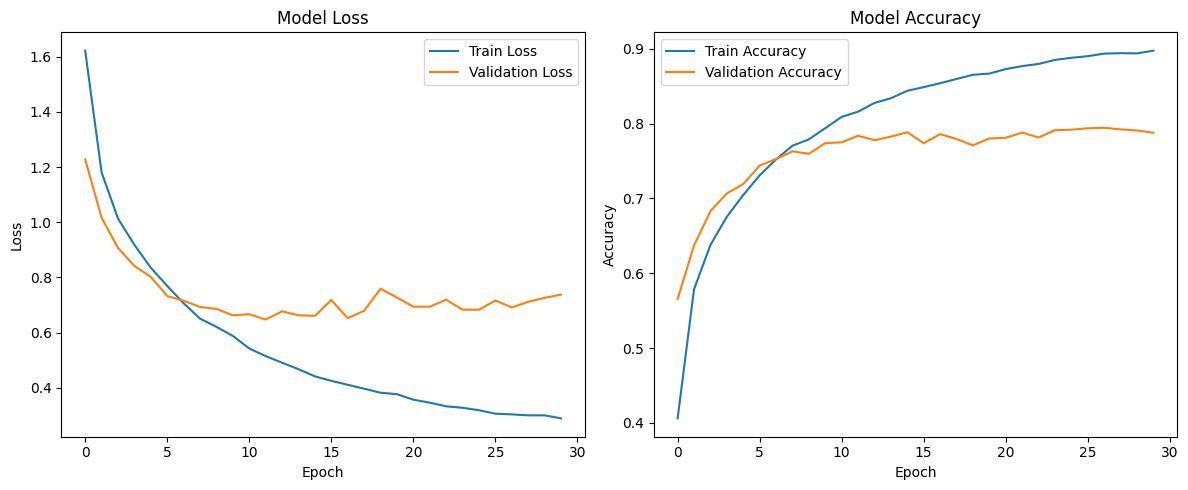

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluating Model Performance

After training, we evaluate the model on the test set to see how well it generalizes to new data.

In [12]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 78.77%


## Data Augmentation

Data augmentation can help improve model robustness by artificially enlarging the dataset through random transformations.

In [13]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train)

# Use the generator in model training
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=30,
                    validation_data=(x_test, y_test))

Epoch 1/30


c:\Users\bigma\.virtualenvs\Pneumonia-Detection-1PsfeFAi\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.6755 - loss: 0.9723 - val_accuracy: 0.7601 - val_loss: 0.7246
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.7070 - loss: 0.8510 - val_accuracy: 0.7559 - val_loss: 0.7219
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.7167 - loss: 0.8227 - val_accuracy: 0.7455 - val_loss: 0.7485
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.7249 - loss: 0.7956 - val_accuracy: 0.7709 - val_loss: 0.6803
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.7243 - loss: 0.7871 - val_accuracy: 0.7799 - val_loss: 0.6564
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.7318 - loss: 0.7747 - val_accuracy: 0.7776 - val_loss: 0.6605
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.7364 - loss: 0.7553 - val_accuracy: 0.7486 - val_loss: 0.7569
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.7358 - loss: 0.7583 - val_accurac

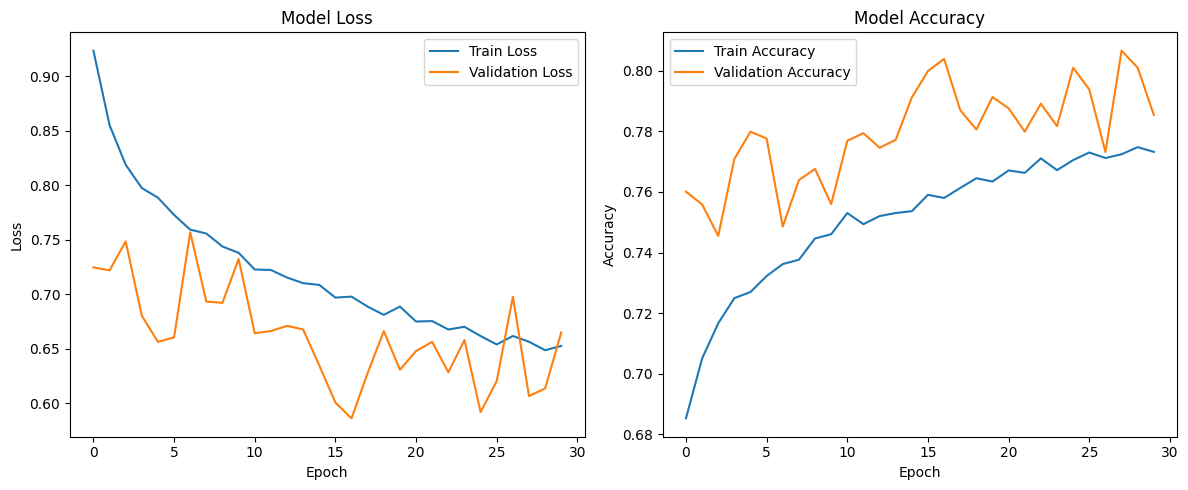

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 78.54%


## Learning Rate Scheduling

While adaptive learning rate algorithms (such as Adam) adapt learning rates on a per-parameter basis, externally scheduling the global learning rate can further refine and stabilize training for better performance. Below is an example of how we can use Keras's LearningRateScheduler callback to dynamically adjust the learning rate during training. In this example, we reduce the learning rate by 10% every 5 epochs.

In [16]:
def lr_schedule(epoch, lr):
    # Decrease the learning rate by 10% every 5 epochs
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.9
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Use the scheduler during training
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=30,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler])


Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.7763 - loss: 0.6409 - val_accuracy: 0.8021 - val_loss: 0.6028 - learning_rate: 0.0010
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.7793 - loss: 0.6401 - val_accuracy: 0.8044 - val_loss: 0.6016 - learning_rate: 0.0010
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.7760 - loss: 0.6453 - val_accuracy: 0.8231 - val_loss: 0.5304 - learning_rate: 0.0010
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.7821 - loss: 0.6304 - val_accuracy: 0.8117 - val_loss: 0.5787 - learning_rate: 0.0010
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.7803 - loss: 0.6329 - val_accuracy: 0.8109 - val_loss: 0.5713 - learning_rate: 0.0010
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.7829 - loss: 0.6316 - val_accuracy: 0.8085 - val_loss: 0.5909 - learning_rate: 9.0000e-04
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 81ms/step - accuracy: 0.7841

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

The following are some situations when it might be beneficial to use a learning rate scheduler:
- If you notice that your training or validation loss stops improving (or even worsens) after several epochs, this might be a sign that your learning rate is too high for fine-tuning in later stages.
- When the loss fluctuates widely without clear progress, lowering the learning rate can help stabilize updates.
- When fine-tuning a model on a new dataset, starting with a higher learning rate and then gradually reducing it can help adjust the pre-trained weights without causing drastic updates.
- Often, the decision comes down to experimenting.

## Combining both learning rate scheduling and early stopping

We can also combine learning rate scheduling with an early stopping callback. The learning rate scheduler adjusts the learning rate to help the optimizer fine-tune the weights over time, while early stopping monitors a chosen metric (e.g., validation loss) to halt training if the model stops improving.

Below is an example that demonstrates how to use both callbacks together.

In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Use both callbacks during training
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=30,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler, early_stopping])

## Model Evaluation

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(model.predict(x_test), axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Visualizing (Mis)Predictions

It is important to check samples on which the model is predicting correctly and also observe mispredictions to see if we can gain some insight of where the model is performing well and were it is failing. In the following example, we randomly select samples from the testing set, make predictions using the trained model, and then visualize the images with both the predicted and ground truth labels. If the prediction is correct, the label text is shown in green; if not, it’s shown in red.

In [ ]:
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Set number of random samples to display
num_samples = 25
random_indices = np.random.choice(len(x_test), num_samples, replace=False)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[idx])
    
    # Retrieve predicted and true label names
    pred_label = class_names[predicted_labels[idx]]
    true_label = class_names[true_labels[idx]]
    
    # Set label color: green if prediction is correct, red otherwise
    color = 'green' if predicted_labels[idx] == true_labels[idx] else 'red'
    
    plt.xlabel(f"P: {pred_label}\nT: {true_label}", color=color)
    
plt.tight_layout()
plt.show()

## Visualize learned filters & produced feature maps

Now we visualize some learned filters in each layer and some produced feature maps. The following examples iterates through each convolutional layer in the model, extracts the learned filters, and visualizes a few random ones for each layer. The code normalizes the filter values for display and handles both single-channel (grayscale) and three-channel (RGB) filters.

In [ ]:
for layer in model.layers:
    # Check if the layer is a Conv2D layer
    if isinstance(layer, tf.keras.layers.Conv2D):
        filters, biases = layer.get_weights()
        # filters shape: (filter_height, filter_width, in_channels, out_channels)
        num_filters = filters.shape[-1]
        print(f"Visualizing filters from layer: {layer.name} with {num_filters} filters")

        # Select a few random filters 
        num_to_show = min(6, num_filters)
        random_filter_indices = np.random.choice(num_filters, num_to_show, replace=False)

        # Create subplots for the selected filters
        n_cols = 3
        n_rows = int(np.ceil(num_to_show / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
        axes = axes.flatten()  # flatten in case of multiple rows

        for i, filter_index in enumerate(random_filter_indices):
            # Get the filter weights: shape (filter_height, filter_width, in_channels)
            filt = filters[:, :, :, filter_index]

            # Normalize filter values to 0-1 for visualization
            f_min, f_max = filt.min(), filt.max()
            filt_norm = (filt - f_min) / (f_max - f_min + 1e-5)  # avoid division by zero
            ax = axes[i]
            # If the filter has 3 channels, display it as an RGB image; otherwise as grayscale.
            if filt_norm.shape[-1] == 3:
                ax.imshow(filt_norm)
            else:
                # For single-channel filters, remove the channel dimension and use a grayscale colormap.
                ax.imshow(filt_norm[:, :, 0], cmap='gray')
            ax.set_title(f'Filter {filter_index}')
            ax.axis('off')
        
        # Hide any extra subplots
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
        
        plt.suptitle(f"Filters from layer: {layer.name}")
        plt.tight_layout()
        plt.show()

Now let's visualize some feature maps corresponding to each layer for a randomly selected testing sample. We select a random test image, compute the intermediate feature maps for each convolutional layer, and visualizes a few randomly chosen feature maps from each layer.

### Note: the following cell runs correctly only with tf version of < 2.15. It will fail on Rosie due to a bug in Keras version 3.

In [ ]:
sample_index = np.random.randint(0, x_test.shape[0])
sample_image = x_test[sample_index]

plt.figure(figsize=(3, 3))
plt.imshow(sample_image)
plt.title("Original Test Image")
plt.axis("off")
plt.show()

sample_image_expanded = np.expand_dims(sample_image, axis=0)  # add batch dimension

# Iterate over the layers in the model
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        # Create a model that outputs the activations of the current layer
        intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer.output)
        
        intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer.output)
        
        feature_maps = intermediate_model.predict(sample_image_expanded)
        # feature_maps shape: (1, height, width, channels)
        num_feature_maps = feature_maps.shape[-1]
        print(f"Visualizing feature maps from layer: {layer.name} with {num_feature_maps} feature maps")
        
        # Randomly select a subset of feature maps to display
        num_to_show = min(6, num_feature_maps)
        random_indices = np.random.choice(num_feature_maps, num_to_show, replace=False)
        
        n_cols = 3
        n_rows = int(np.ceil(num_to_show / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
        axes = axes.flatten()
        
        for i, fmap_index in enumerate(random_indices):
            fmap = feature_maps[0, :, :, fmap_index]
            # Normalize the feature map to [0, 1] for visualization
            fmap_norm = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)
            axes[i].imshow(fmap_norm, cmap='viridis')
            axes[i].set_title(f"Map {fmap_index}")
            axes[i].axis("off")
        
        # Hide any unused subplots if necessary
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")
        
        plt.suptitle(f"Feature Maps from layer: {layer.name}")
        plt.tight_layout()
        plt.show()

## Comparison with a DNN model

Now we apply a dense (fully connected) neural network architecture and compare its performance with CNN. Unlike a CNN that leverages spatial structure via convolutional layers, this dense model first flattens the image and then uses several Dense layers for classification.

In [ ]:
model_dense = Sequential()
model_dense.add(Flatten(input_shape=x_train.shape[1:]))    # Flatten the image from (32, 32, 3) to a 1D vector of 3072 elements
model_dense.add(Dense(512, activation='relu'))     # First hidden layer with 512 units and ReLU activation
# model_dense.add(Dropout(0.5))  # Dropout for regularization
model_dense.add(Dense(256, activation='relu'))     # Second hidden layer with 256 units and ReLU activation
# model_dense.add(Dropout(0.5))
model_dense.add(Dense(num_classes, activation='softmax'))      # Output layer with softmax activation for multi-class classification

# Compile the dense model using the Adam optimizer and categorical crossentropy loss
model_dense.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Train the dense model
history_dense = model_dense.fit(x_train, y_train,
                                epochs=30,
                                batch_size=64,
                                validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model_dense.evaluate(x_test, y_test, verbose=0)
print(f"Dense model test accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Plot training & validation loss values
plt.plot(history_dense.history['loss'], label='Train Loss')
plt.plot(history_dense.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dense.history['accuracy'], label='Train Accuracy')
plt.plot(history_dense.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Practical Tips 

- Experiment with architectures 
    - There’s no one-size-fits-all model. Experiment with the number of layers, filter sizes, and hyperparameters.
- Monitor training
    - Use callbacks to track training progress and avoid overfitting.
- Preprocessing matters
    - Ensure your data is properly normalized and augmented where appropriate.
- Leverage transfer learning
    - Pre-trained models can significantly boost performance, especially with limited data.
- Document and iterate
    - Keep detailed records of experiments and adjustments to refine your model over time.